In [ ]:
!pip install wfdb

In [2]:
import wfdb
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

Plotting the first signal

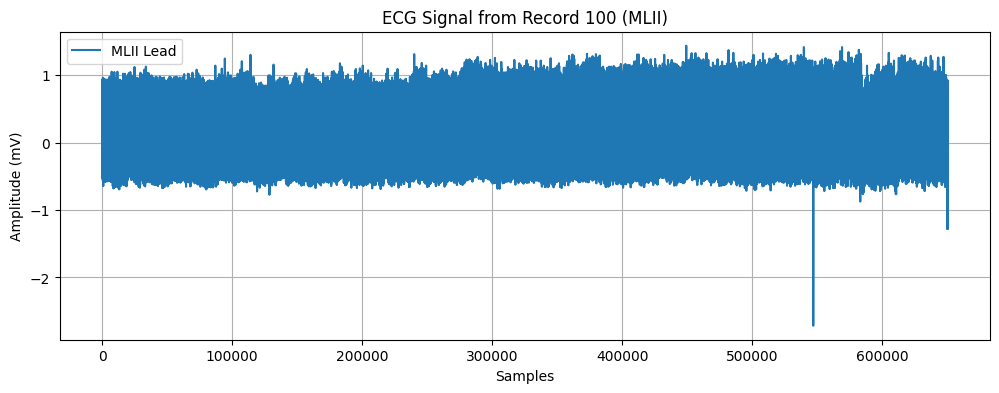

In [3]:
record = wfdb.rdrecord('100', pn_dir='mitdb')
signal = record.p_signal
fs = record.fs

plt.figure(figsize=(12, 4))
plt.plot(signal[:, 0], label='MLII Lead')
plt.title('ECG Signal from Record 100 (MLII)')
plt.xlabel('Samples')
plt.ylabel('Amplitude (mV)')
plt.legend()
plt.grid(True)
plt.show()

Extract a readable portion from this

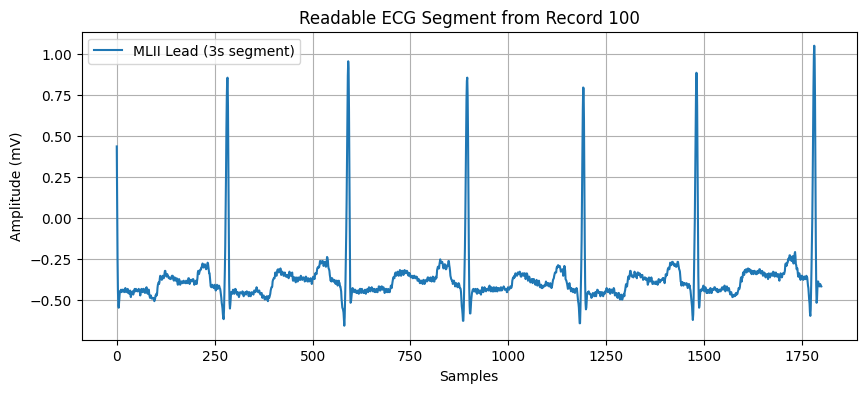

In [5]:
record = wfdb.rdrecord('100', pn_dir='mitdb')
signal = record.p_signal
fs = record.fs

start = 10000
end = start + 5 * fs

segment = signal[start:end, 0]

plt.figure(figsize=(10, 4))
plt.plot(segment, label='MLII Lead (3s segment)')
plt.title('Readable ECG Segment from Record 100')
plt.xlabel('Samples')
plt.ylabel('Amplitude (mV)')
plt.legend()
plt.grid(True)
plt.show()

Extracting features

In [6]:
import os

In [7]:
record_ids = [f.split('.')[0] for f in os.listdir() if f.endswith('.dat')]
record_ids = sorted(list(set(record_ids)))

In [8]:
all_features = []

In [9]:
from scipy.stats import skew, kurtosis
from scipy.signal import welch
from scipy.integrate import simpson

sampling_rate = 360
all_features = []

for rid in record_ids:
    try:
        record = wfdb.rdrecord(rid)
        annotation = wfdb.rdann(rid, 'atr')
        signal = record.p_signal[:, 0]
        samples = annotation.sample
        labels = annotation.symbol

        rr_intervals = np.diff(samples)

        for i in range(1, len(samples)):
            rr = samples[i] - samples[i - 1]
            beat_time = samples[i]
            window = signal[max(0, beat_time - 50): beat_time + 50]

            # Time-domain HRV features
            rmssd = np.sqrt(np.mean(np.square(np.diff(rr_intervals)))) if len(rr_intervals) > 1 else 0
            nn50 = np.sum(np.abs(np.diff(rr_intervals)) > 50) if len(rr_intervals) > 1 else 0
            pnn50 = nn50 / len(rr_intervals) if len(rr_intervals) > 0 else 0
            sdnn = np.std(rr_intervals) if len(rr_intervals) > 0 else 0

            # Frequency-domain HRV features
            fxx, pxx = welch(rr_intervals, fs=sampling_rate, nperseg=min(256, len(rr_intervals)))
            lf_power = np.sum(pxx[(fxx >= 0.04) & (fxx <= 0.15)])
            hf_power = np.sum(pxx[(fxx >= 0.15) & (fxx <= 0.4)])
            lf_hf_ratio = lf_power / hf_power if hf_power != 0 else 0

            # Morphological features
            slope = np.mean(np.gradient(window))
            auc = simpson(np.abs(window))
            peak_to_peak = np.ptp(window)
            zero_crossings = np.sum(np.diff(np.sign(window - np.mean(window))) != 0)

            all_features.append({
                'record': rid,
                'rr_interval': rr,
                'heart_rate': 60 / (rr / sampling_rate),
                'mean_amp': np.mean(window),
                'std_amp': np.std(window),
                'max_amp': np.max(window),
                'skewness': skew(window),
                'kurtosis': kurtosis(window),
                'rmssd': rmssd,
                'nn50': nn50,
                'pnn50': pnn50,
                'sdnn': sdnn,
                'lf_power': lf_power,
                'hf_power': hf_power,
                'lf_hf_ratio': lf_hf_ratio,
                'slope': slope,
                'auc': auc,
                'peak_to_peak': peak_to_peak,
                'zero_crossings': zero_crossings,
                'label': labels[i]
            })
    except Exception as e:
        print(f"Error processing record {rid}: {e}")

Make csv file

In [10]:
df_all = pd.DataFrame(all_features)
df_all.to_csv('mitbih_all_features.csv', index=False)

Read data from csv file

In [11]:
import matplotlib.pyplot as plt

In [12]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [13]:
df = pd.read_csv('mitbih_all_features.csv')


printing first five row after feature extraction

In [14]:
df.head()

,record,rr_interval,heart_rate,mean_amp,std_amp,max_amp,skewness,kurtosis,rmssd,nn50,pnn50,sdnn,lf_power,hf_power,lf_hf_ratio,slope,auc,peak_to_peak,zero_crossings,label
0,100,59,366.101695,-0.24895,0.246365,0.84,3.218379,9.815595,23.281895,88,0.038715,18.210363,0.0,0.0,0,-0.001300,32.987083,1.325,3,N
1,100,293,73.720137,-0.27345,0.301508,0.94,2.907049,7.582941,23.281895,88,0.038715,18.210363,0.0,0.0,0,-0.001825,38.158333,1.475,3,N
2,100,292,73.972603,-0.30640,0.280517,0.96,3.256670,10.187483,23.281895,88,0.038715,18.210363,0.0,0.0,0,-0.001200,39.338750,1.530,3,N
3,100,284,76.056338,-0.32810,0.270488,0.86,3.133722,9.579635,23.281895,88,0.038715,18.210363,0.0,0.0,0,-0.001300,40.680000,1.505,3,N
4,100,285,75.789474,-0.31960,0.248368,0.82,3.376301,10.964326,23.281895,88,0.038715,18.210363,0.0,0.0,0,-0.001775,38.935833,1.385,3,N


Data labelling

In [15]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()

df.iloc[:, 19] = le.fit_transform(df.iloc[:, 19])


In [16]:
x = df.iloc[:,:-1].values
y = df.iloc[:,-1].values
y = y.astype(int)


Printing first five rows after labelling

In [17]:
df.head()

,record,rr_interval,heart_rate,mean_amp,std_amp,max_amp,skewness,kurtosis,rmssd,nn50,pnn50,sdnn,lf_power,hf_power,lf_hf_ratio,slope,auc,peak_to_peak,zero_crossings,label
0,100,59,366.101695,-0.24895,0.246365,0.84,3.218379,9.815595,23.281895,88,0.038715,18.210363,0.0,0.0,0,-0.001300,32.987083,1.325,3,9
1,100,293,73.720137,-0.27345,0.301508,0.94,2.907049,7.582941,23.281895,88,0.038715,18.210363,0.0,0.0,0,-0.001825,38.158333,1.475,3,9
2,100,292,73.972603,-0.30640,0.280517,0.96,3.256670,10.187483,23.281895,88,0.038715,18.210363,0.0,0.0,0,-0.001200,39.338750,1.530,3,9
3,100,284,76.056338,-0.32810,0.270488,0.86,3.133722,9.579635,23.281895,88,0.038715,18.210363,0.0,0.0,0,-0.001300,40.680000,1.505,3,9
4,100,285,75.789474,-0.31960,0.248368,0.82,3.376301,10.964326,23.281895,88,0.038715,18.210363,0.0,0.0,0,-0.001775,38.935833,1.385,3,9


Splitting into training and test data

In [18]:
from sklearn.model_selection import train_test_split
X_train,X_test,Y_train,Y_test = train_test_split(x,y,test_size=0.2,random_state=0)

In [19]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.fit_transform(X_test)

In [20]:
print(np.unique(y))
print(y.dtype)

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22]
int64


Applying Random Forest Algorithm

In [21]:
from sklearn.ensemble import RandomForestClassifier
model_randomforest = RandomForestClassifier()
model_randomforest.fit(X_train,Y_train)

RandomForestClassifier()

In [22]:
from sklearn.metrics import confusion_matrix , accuracy_score


In [23]:
y_pred_random = model_randomforest.predict(X_test)

In [24]:
RandomForest_Accuracy = accuracy_score(Y_test,y_pred_random)

Text(0, 0.5, 'Accuracy')

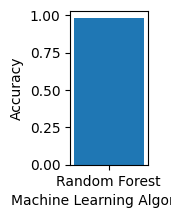

In [25]:
plt.figure(figsize=(1, 2))
plt.bar("Random Forest",RandomForest_Accuracy,width=0.6)
plt.xlabel("Machine Learning Algorithm")
plt.ylabel("Accuracy")

In [26]:
print(RandomForest_Accuracy*100)

98.16607460035523


Showing a random result using random forest

In [27]:
df.iloc[226:227]

,record,rr_interval,heart_rate,mean_amp,std_amp,max_amp,skewness,kurtosis,rmssd,nn50,pnn50,sdnn,lf_power,hf_power,lf_hf_ratio,slope,auc,peak_to_peak,zero_crossings,label
226,100,286,75.524476,-0.35495,0.256924,0.805,3.298087,10.317204,23.281895,88,0.038715,18.210363,0.0,0.0,0,-0.001925,42.35,1.39,3,9


In [28]:
result = model_randomforest.predict(sc.transform([[100,	286,	75.524476,	-0.35495,	0.256924,	0.805,	3.298087,	10.317204,	23.281895,	88,	0.038715,	18.210363,	0.0,	0.0,	0,	-0.001925,	42.350000,	1.390,	3]]))
print(result)

[9]


Printing confusion matrix and classification report

Accuracy: 0.9816607460035524
Precision: 0.8121781174677425
Recall: 0.7005995659226286
F1 Score: 0.7367582566708849


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


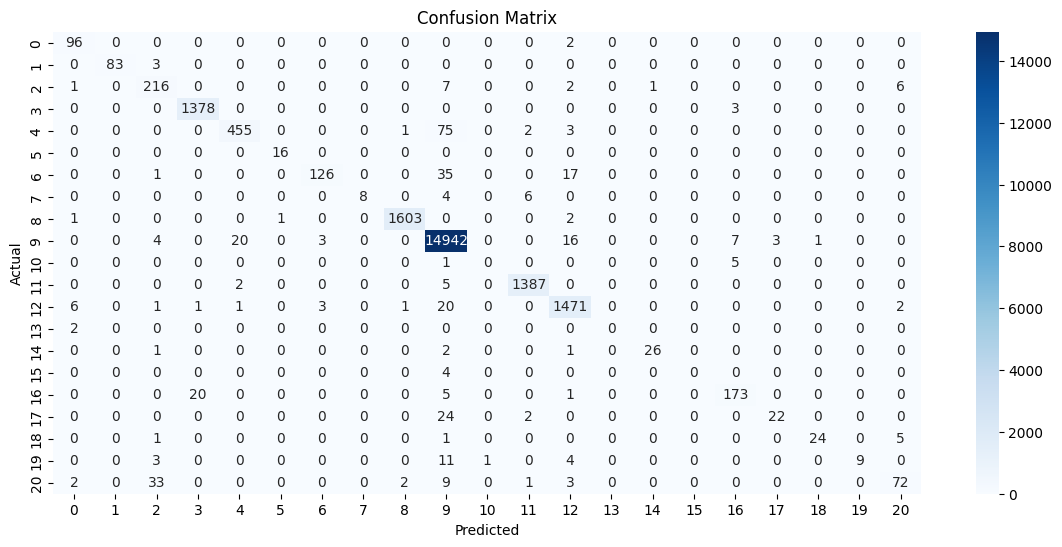


Classification Report:

              precision    recall  f1-score   support

           0       0.89      0.98      0.93        98
           1       1.00      0.97      0.98        86
           2       0.82      0.93      0.87       233
           3       0.98      1.00      0.99      1381
           4       0.95      0.85      0.90       536
           5       0.94      1.00      0.97        16
           6       0.95      0.70      0.81       179
           7       1.00      0.44      0.62        18
           8       1.00      1.00      1.00      1607
           9       0.99      1.00      0.99     14996
          10       0.00      0.00      0.00         6
          11       0.99      0.99      0.99      1394
          13       0.97      0.98      0.97      1506
          14       0.00      0.00      0.00         2
          16       0.96      0.87      0.91        30
          17       0.00      0.00      0.00         4
          18       0.92      0.87      0.89       199
  

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [29]:
from sklearn.metrics import (
    precision_score, recall_score, f1_score, roc_auc_score,
    classification_report, confusion_matrix
)
import seaborn as sns

# Predictions
y_prob_random = model_randomforest.predict_proba(X_test)[:, 1]  # for ROC-AUC (binary only)

# Metrics
print("Accuracy:", accuracy_score(Y_test, y_pred_random))
print("Precision:", precision_score(Y_test, y_pred_random, average='macro'))
print("Recall:", recall_score(Y_test, y_pred_random, average='macro'))
print("F1 Score:", f1_score(Y_test, y_pred_random, average='macro'))

# ROC-AUC (only for binary classification)
if len(np.unique(Y_test)) == 2:
    print("ROC-AUC:", roc_auc_score(Y_test, y_prob_random))

# Confusion Matrix
cm = confusion_matrix(Y_test, y_pred_random)
plt.figure(figsize=(14, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# Classification Report
print("\nClassification Report:\n")
print(classification_report(Y_test, y_pred_random))


Comparing with some other models

In [30]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.metrics import accuracy_score

# Initialize models
models = {
    "Random Forest": RandomForestClassifier(),
    "Decision Tree": DecisionTreeClassifier(),
    "K-Nearest Neighbors": KNeighborsClassifier(),
    "SVM": SVC(),
    "Logistic Regression": LogisticRegression(),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='mlogloss'),
    "LightGBM": LGBMClassifier()
}

# Train and evaluate
accuracies = {}

for name, model in models.items():
    model.fit(X_train, Y_train)
    y_pred = model.predict(X_test)
    acc = accuracy_score(Y_test, y_pred)
    accuracies[name] = acc
    print(f"{name} Accuracy: {acc:.4f}")


Random Forest Accuracy: 0.9823
Decision Tree Accuracy: 0.9706
K-Nearest Neighbors Accuracy: 0.9759
SVM Accuracy: 0.9742


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy: 0.9075


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [14:15:19] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


XGBoost Accuracy: 0.9430
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.014629 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2825
[LightGBM] [Info] Number of data points in the train set: 90079, number of used features: 16
[LightGBM] [Info] Start training from score -5.484187
[LightGBM] [Info] Start training from score -5.547656
[LightGBM] [Info] Start training from score -4.489747
[LightGBM] [Info] Start training from score -2.769563
[LightGBM] [Info] Start training from score -3.802552
[LightGBM] [Info] Start training from score -6.908633
[LightGBM] [Info] Start training from score -4.972292
[LightGBM] [Info] Start training from score -7.234055
[LightGBM] [Info] Start training from score -2.633820
[LightGBM] [Info] Start training from score -0.405410
[LightGBM] [Info] Start training from score -8.112605
[LightGBM] [Info] Start training from score -2.731685
[LightGBM] [Info] Start training from 

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


LightGBM Accuracy: 0.6204


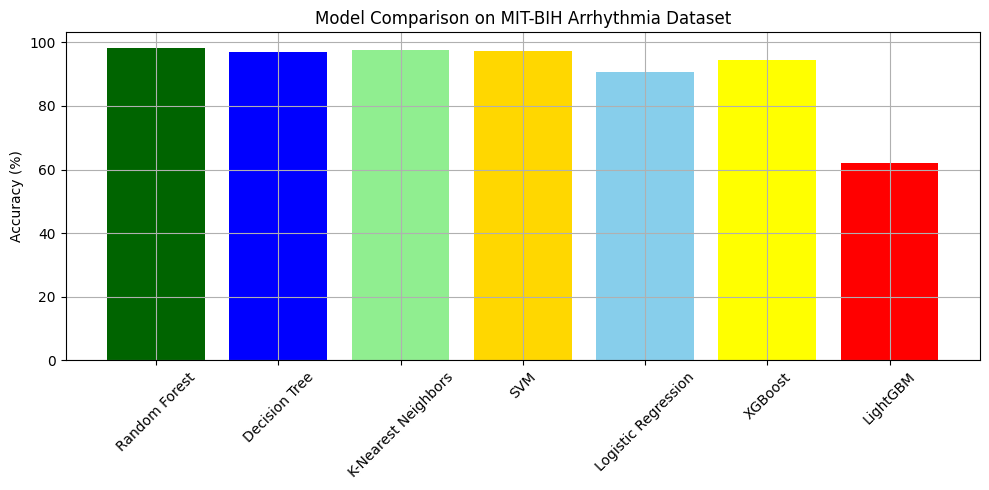

In [31]:
import matplotlib.pyplot as plt

# Define custom colors for each model
colors = ['darkgreen', 'blue', 'lightgreen', 'gold', 'skyblue', 'yellow', 'red']

# Plot
plt.figure(figsize=(10, 5))
plt.bar(accuracies.keys(), [v*100 for v in accuracies.values()], color=colors)
plt.ylabel("Accuracy (%)")
plt.title("Model Comparison on MIT-BIH Arrhythmia Dataset")
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()
